<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Turning_my_sister_into_an_old_painting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turning my sister into an old painting 
This notebook will explore the magic of GANs. <br>
We are going to refer to a particular GAN architecture : the **Cycle GAN**. 


> ### The goal? <br>Taking a picture of my beautiful sister and turn it into an old painting, to see how she would have looked like a few centuries ago. 


To do this we are going to need 3 things: 
  1. A picture of my sister 
  2. An implementation of *cycle GAN* 
  3. A rich enough collection of portaits of ladies from the past

### Let's get started!

The first thing we do is (1).

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

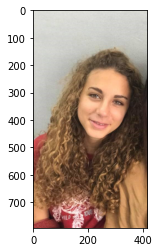

In [0]:
mysisterpic = "../mysister.jpg"
img = mpimg.imread(mysisterpic)
plt.imshow(img)

Now that (1) is done, we're going to jump to (3) before continuing to (2). 
## Building a dataset


The magic of the Cycle GAN model is that it doesn't need paired datasets. All it needs is an instance of the input set and an instance of the output set. To build the dataset we are going to download two sets of images from Google images, one with women paintings and one with actual women pictures. 

In [1]:
!git clone https://github.com/ultralytics/google-images-download

Cloning into 'google-images-download'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 710 (delta 0), reused 1 (delta 0), pack-reused 707
Receiving objects: 100% (710/710), 301.27 KiB | 934.00 KiB/s, done.
Resolving deltas: 100% (398/398), done.


In [0]:
## download selenium and the chrome driver 
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [0]:
%%bash 

#!/bin/bash 

# a script to download google images
cd google-images-download
python3 bing_scraper.py --search 'Women old painting oil' --limit 200 --download --chromedriver chromedriver
python3 bing_scraper.py --search 'woman picture face photography portrait' --limit 200 --download --chromedriver chromedriver

In [0]:
paintings_folder = "google-images-download/images/Women_old_painting_oil"
pictures_folder = "google-images-download/images/woman_picture_face_photography_portrait"

In [0]:
from os import listdir
from os.path import isfile, join
paintings_files = [f for f in listdir(paintings_folder) if isfile(join(paintings_folder, f))]
pictures_files = [f for f in listdir(pictures_folder) if isfile(join(pictures_folder, f))]

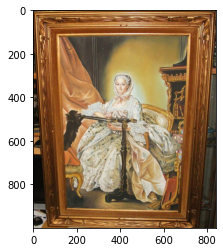

In [22]:
img = mpimg.imread(join(paintings_folder,paintings_files[5]))
plt.imshow(img)

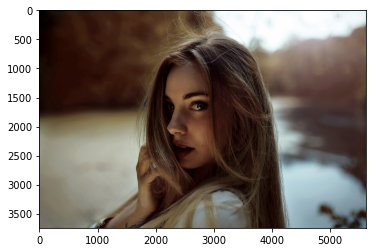

In [28]:
img = mpimg.imread(join(pictures_folder,pictures_files[100]))
plt.imshow(img)

Now that the data is actually here there's only one last step separating us from the actuall model coding. <br> 
We need to split each dataset into two folders: one that will be used during training and one that will only be used at testing time. 

In [0]:
import numpy as np

In [0]:
# first set the percentage of the data to be held-out
test_split = 0.2
total = 200 # this is the total number of images we have for each category 
test_total = int(test_split*total)
# sample without replacement, aka shuffle
indices = np.random.choice(a = range(0,total), size=total, replace=False) 
# first 20% of indices will go to test
train_indices = indices[test_total:total]
test_indices = indices[0:test_total]

In [35]:
test_indices

array([ 23, 122, 174,  31, 198, 172, 131,  82, 133,   6,  77,  59, 159,
       161, 102, 136, 127,  88,  85,  98, 197, 185, 155, 193, 111,  57,
       191, 180, 157, 149, 113, 108, 184,  22,  66, 190,  95, 132, 137,
        65])

In [0]:
# load images: not necessary 
print("Loading training and testing data")
train_paintings = [mpimg.imread(join(paintings_folder,paintings_files[i])) for i in train_paintings_indices]
test_paintings = [mpimg.imread(join(paintings_folder,paintings_files[i])) for i in test_paintings_indices]
train_pictures = [mpimg.imread(join(pictures_folder,pictures_files[i])) for i in train_pictures_indices]
test_pictures = [mpimg.imread(join(pictures_folder,pictures_files[i])) for i in test_pictures_indices]
print("Loaded.")

## The model : Cycle GAN

We'll be using Tensorflow 2 to implement the Cycle GAN as described in [this paper](https://arxiv.org/pdf/1703.10593.pdf).

### Data preprocessing

In [0]:
import tensorflow as tf

Here are some plotting helper functions, which are going to become useful later on. 

In [0]:
import os 

def plotQuartet(self, plot_images, epoch):
  """ Takes 2 pairs of images in [pre-post] ordering 
      and plot them in a grid. 
  """
  titles = ['Original', 'Transformed']
  fig, axs = plt.subplots(2, 2)
  cnt = 0
  for i in range(2):
      for j in range(2):
          axs[i,j].imshow(plot_images[cnt])
          axs[i, j].set_title(titles[j])
          axs[i,j].axis('off')
          cnt += 1
  plt.close()

def plot20(self, images):
  """Plots the first 20 images of the list"""
    plt.figure(figsize=(10, 8))
    for i in range(20):
        img = plt.imread(images[i])
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(img.shape)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [0]:
print("Preprocessing ...")
train_x = train_pictures.map(preprocess_image)
train_y = train_paintings.map(preprocess_image)
test_x = test_pictures.map(preprocess_image)
test_y = test_paintings.map(preprocess_image)
print("Done.")